##### Modelo SEIR (Susceptibles, Expuestos, Infectados, Detectados, Recuperados, Fallecidos) + Contactos

In [1]:
import numpy as np
import scipy
import scipy.integrate
import lmfit

from utilidades import *

def seir_model(SEIR, beta, sigma, gamma, mu, theta=0, beta_d=0, omega=0):
    S, E, C, I, D, R, F = SEIR

    # Poblacion
    N = S + E + C + I + D + R

    # - Los susceptibles que pasan a expuestos a razon `beta` (infectados no detectados)
    # - Los susceptibles que pasan a expuestos a razon `beta_d` (infectados detectados)
    dS = - beta * S * I / N - beta_d * S * D / N
    # + Los susceptibles que pasan a expuestos a razon `beta` (infectados no detectados)
    # - Los expuestos que pasan a infectados a razon `sigma`
    dE = beta * S * I / N - sigma * E
    # + Los susceptibles que pasan a expuestos a razon `beta_d` (infectados detectados)
    # - Los expuestos que pasan a infectados o detectados a razon `sigma`
    dC = beta_d * S * D / N - sigma * C
    # + Los expuestos que pasan a infectados no detectados a razon `sigma`
    # + Los contactos que pasan a infectados a razon `sigma * (1 - omega)`
    # - Los infectados no detectados que pasan a recuperados a razon `gamma`
    # - Los infectados no detectados que pasan a fallecidos a razon `mu`
    # - Los infectados no detectados que pasan a detectados a razon `theta`
    dI = sigma * E + (1 - omega) * sigma * C - gamma * I - mu * I - theta * I
    # + Los infectados no detectados que pasan a detectados a razon `theta`
    # + Los contactos que pasan a infectados a razon `sigma * omega`
    # - Los detectados que pasan a recuperados a razon `gamma`
    # - Los detectados que pasan a fallecidos a razon `mu`
    dD = theta * I + omega * sigma * C - gamma * D - mu * D
    # + Los infectados no detectados que pasan a recuperados a razon `gamma`
    # + Los detectados que pasan a recuperados a razon `gamma`
    dR = gamma * I + gamma * D
    # + Los infectados no detectados que pasan a fallecidos a razon `mu`
    # + Los detectados que pasan a fallecidos a razon `mu`
    dF = mu * I + mu * D

    return [
        dS, dE, dC, dI, dD, dR, dF
    ]

Clases:
    * Susceptible
    * Expuesto
    * Infectado
    * Detectado - Infectado Detectado
    * Recuperado
    * Fallecido
Nueva Clase:
    * Contacto - Expuesto Detectado
    
Parametros:  
    * `beta` es la razon de transmision  
    * `sigma` es la razon de transicion de Expuesto a Infectado  
    * `gamma` es la razon de transicion de Infectado a Recuperado (o aislado)  
    * `mu` es la razon de transicion de Infectado a Fallecido
    * `theta` es la razon de transicion de Infectado a Detectado  
    * `beta_d` es la razon de transmision de los Detectados  
Nuevos Parametros:  
    * `omega` por ahora es el % de efectividad de la medida de seguimiento de contactos


In [2]:
periodo_incubacion = 5.2
periodo_infeccioso = 12.4
razon_mortalidad = 3.4 / 100.0 # OMS, best fit

infectados_t0 = 16. # Best fit
susceptibles_t0 = 11e6

data = load_data()

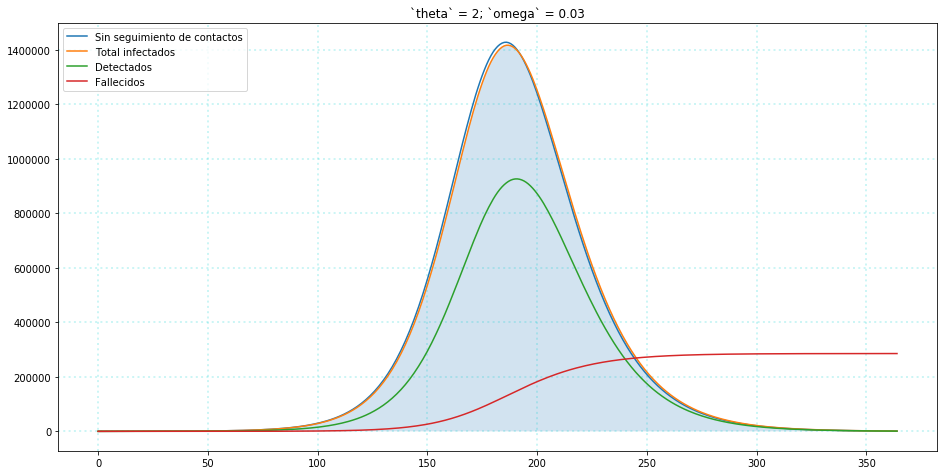

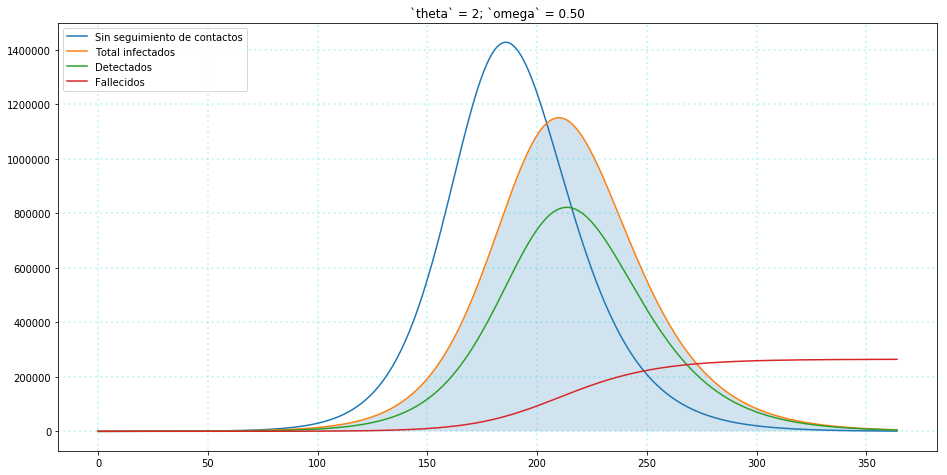

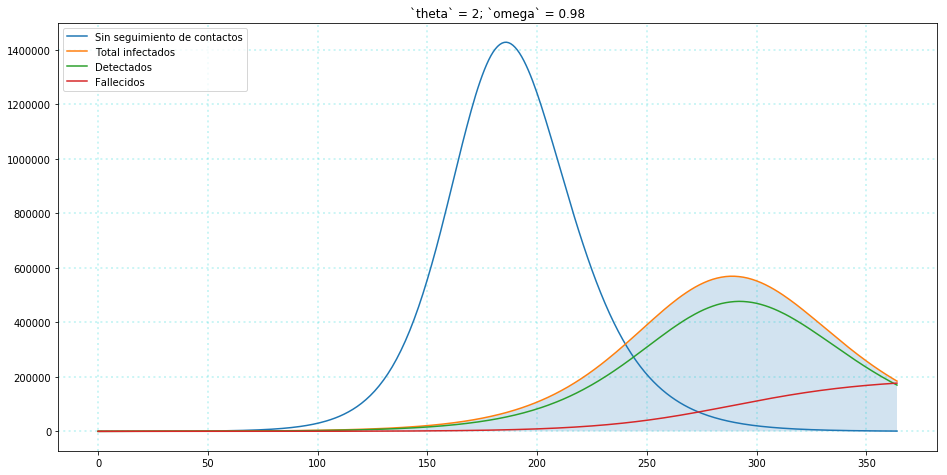

In [3]:
def run_model(params):
    if type(params) == lmfit.Parameters:
        params = [param.value for param in params.values()]
        
    if len(params) > 3:
        R0, R1, theta, omega = params
        beta = [R_t / periodo_infeccioso for R_t in (R0, R1)]
    else:
        R0, theta, omega = params
        beta = R0 / periodo_infeccioso
    
    SEIR_t0 = (
        susceptibles_t0,
        infectados_t0 * R0, # expuestos
        0, # contactos
        infectados_t0,
        0, 0, 0 # detectados, recuperados, fallecidos
    )
    return run(
        seir_model,
        SEIR_t0,
        beta = beta,
        sigma = 1. / periodo_incubacion,
        gamma = 1. / periodo_infeccioso,
        mu = razon_mortalidad / periodo_infeccioso,
        theta = theta / periodo_infeccioso,
        beta_d = 1. / periodo_infeccioso,
        omega = omega,
        days = days,
        step = 1
    )

days = 365

var_range = np.arange(start=0., stop=1., step=0.025)
complete_solutions = {}

for theta in range(1, 4):
    solutions = [
        (var, run_model((4., theta, var))) for var in var_range
    ]
    complete_solutions[theta] = solutions

solutions = complete_solutions[2]
solutions_x = solutions[0][1]['t']
solution_base = solutions[0][1]['y'][4] + solutions[0][1]['y'][3]

for _ in range(1, 40, 19):
    solution_infected = solutions[_][1]['y'][4] + solutions[_][1]['y'][3]

    ax = plot(solutions_x, solution_base, labels=['Sin seguimiento de contactos'])
    ax.plot(solutions_x, solution_infected, label='Total infectados')
    ax.plot(solutions_x, solutions[_][1]['y'][4], label='Detectados')
    ax.plot(solutions_x, solutions[_][1]['y'][-1], label='Fallecidos')
    ax.fill_between(
        solutions_x,
        [0] * len(solutions_x),
        solution_infected,
        alpha=0.2
    )
    ax.set_title('`theta` = 2; `omega` = {:.2f}'.format(solutions[_][0]))
    ax.legend(loc='upper left')

`omega` esta relacionado a la definicion de contacto y a la capacidad de hacer el seguimiento.  
TODO: Cuantos y como se distribuye la cantidad de contactos?

La curva `Sin tests` se genera a partir de un `R0` = 4.0 y `theta` = 2.0.  

###### Cual es la capacidad de seguimiento de contactos necesaria? como afecta a la curva de contagios?  

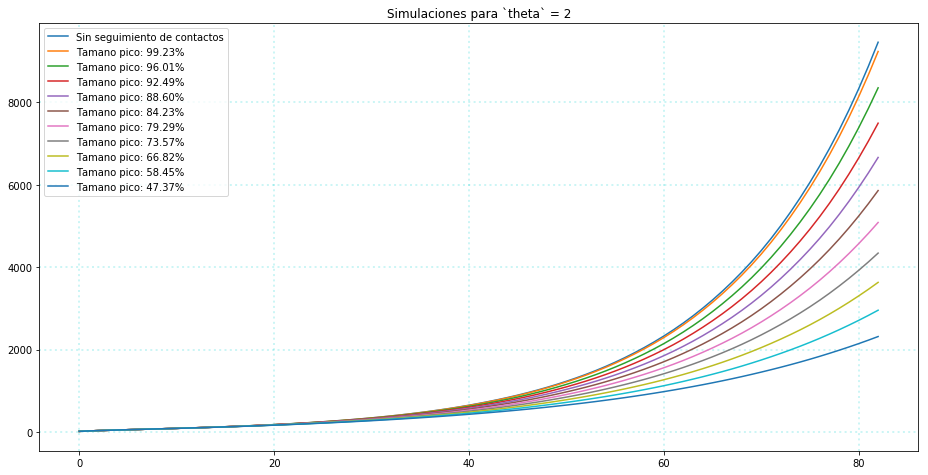

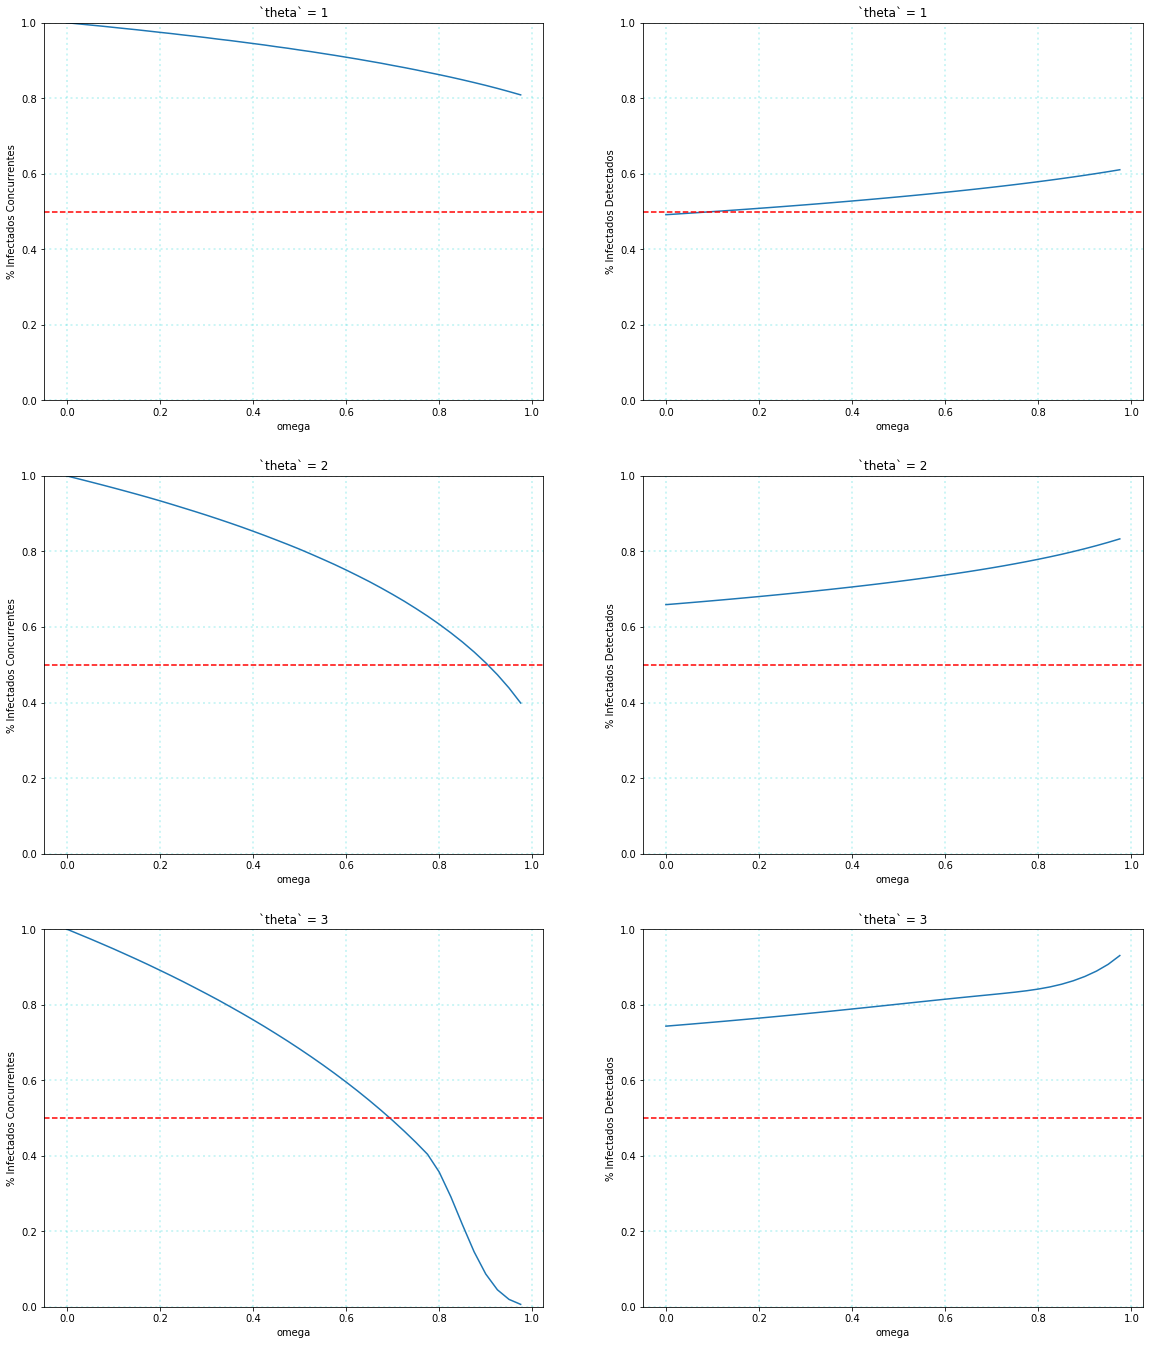

In [4]:
def get_metrics(solutions):
    solution_base = solutions[0][1]['y'][4] + solutions[0][1]['y'][3]
    total_infected = [
        solutions[_][1]['y'][4] + solutions[_][1]['y'][3] for _ in range(len(solutions))
    ]
    concurrent_infected = [
        max(total_infected[_]) / max(solution_base) for _ in range(len(solutions))
    ]
    percentage_detected = [
        sum(solutions[_][1]['y'][4]) / sum(total_infected[_]) for _ in range(len(solutions))
    ]
    
    return (concurrent_infected, percentage_detected)

to_day = len(data[0]) + 30
solutions_x_capped = solutions_x[:to_day]

ax = plot(solutions_x_capped, solution_base[:to_day], labels=['Sin seguimiento de contactos'])
ax.set_title('Simulaciones para `theta` = 2')

concurrent_infected, _ = get_metrics(solutions)

for _ in range(1, len(solutions), int(len(solutions)/10)):
    solution_infected = solutions[_][1]['y'][4] + solutions[_][1]['y'][3]
    ax.plot(
        solutions_x_capped,
        solution_infected[:to_day],
        label='Tamano pico: {:.2f}%'. format(concurrent_infected[_] * 100)
    )
    ax.legend(loc='upper left')


labels = ['% Infectados Concurrentes', '% Infectados Detectados']
fig, axs = pyplot.subplots(figsize=(50 / 2.54, 3 * 20 / 2.54), ncols=2, nrows=3)

# Simulaciones para `theta` de 1 a 3
for solution_idx in range(1, 4):
    metrics = get_metrics(complete_solutions[solution_idx])
    ax_row = axs[solution_idx - 1]
    
    for idx, ax in enumerate(ax_row):
        ax.plot(var_range, metrics[idx])
        ax.axhline(y=0.5, color='r', linestyle='--')
        ax.set(xlabel='omega', ylabel=labels[idx])
        ax.set_title('`theta` = {}'.format(solution_idx))
        ax.set_ylim(bottom=0, top=1.)
        ax.grid( color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)


TODO: Describir

###### Regresion 

In [5]:
days = [20, len(data[0]) - 20]
razon_mortalidad = 3. / 100.0

def naive_lmfit():
    params = lmfit.Parameters()
    params.add('R0', value=3., min=1.6, max=4.8)
    params.add('theta', value=3., min=1., max=4.)
    params.add('omega', value=.5, min=.1, max=.9)
    
    def sqsum(R_ts):
        solution = run_model(R_ts)
        solution_data = np.array(solution['y'])
        
        return (solution_data[(4, 6),] - data[(0, 2),])
    
    return lmfit.minimize(sqsum, params, method='differential_evolution')

R_ts = naive_lmfit()
R_ts

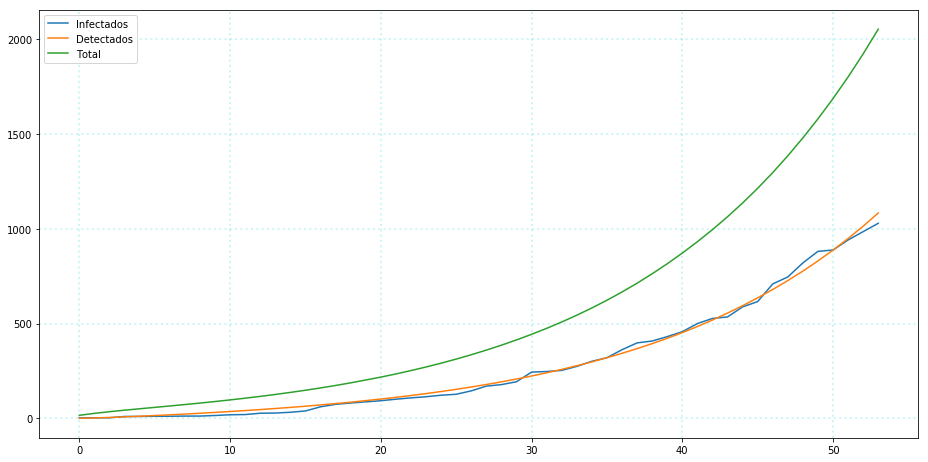

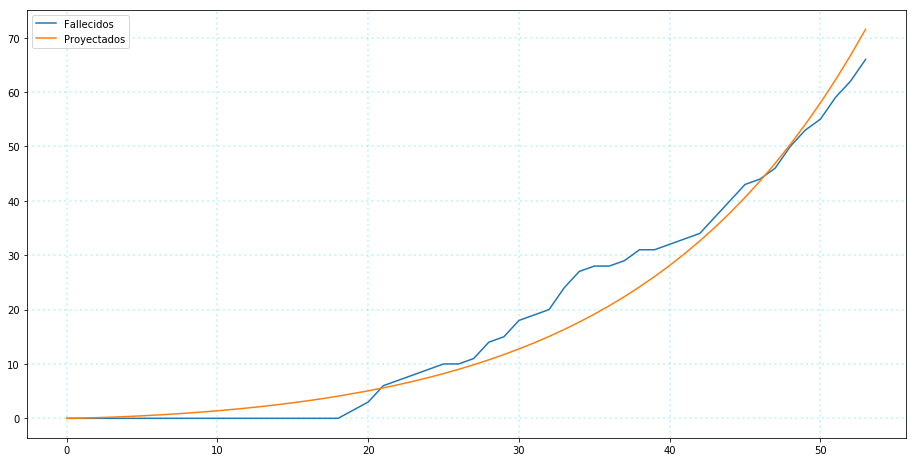

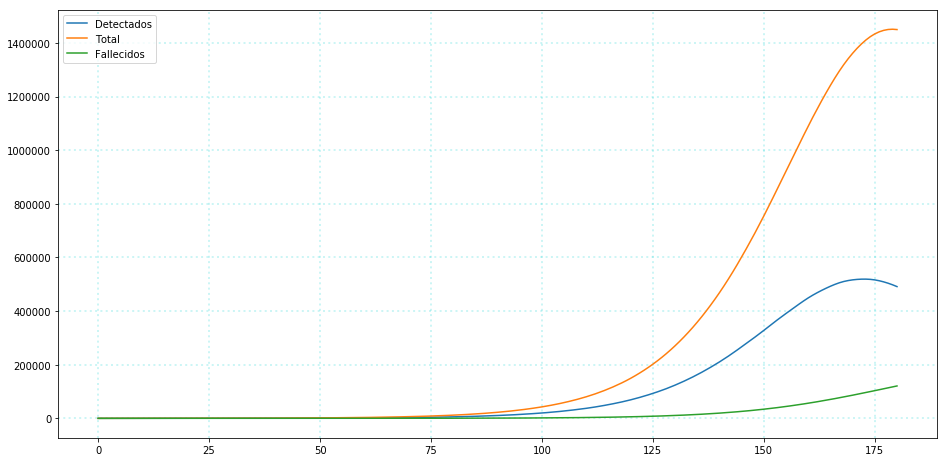

In [6]:
solution = run_model(R_ts.params)

plot(
    solution['t'], 
    data[0], solution['y'][4], solution['y'][4] + solution['y'][3],
    labels=[
        'Infectados', 'Detectados', 'Total',
    ]
)

plot(
    solution['t'], 
    data[2], solution['y'][6],
    labels=[
        'Fallecidos', 'Proyectados',
    ]
)
days = [20, 180 - 20]
solution = run_model(R_ts.params)

_ = plot(
    solution['t'], 
    solution['y'][3], solution['y'][4] + solution['y'][3], solution['y'][6],
    labels=[
        'Detectados', 'Total', 'Fallecidos'
    ]
)

Notas:
* nada el fitting...

Que hacer ahora?
* Agregar estructura